In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Explore Data

In [51]:
df = pd.read_csv('./GSE150150_raw_counts.csv')

In [52]:
print("Gene Count: ", len(df))
sampleRow = df.sample()
print("Sample Row: ", sampleRow)
print("Sample Gene: ", sampleRow.iloc[0,0])

Gene Count:  24582
Sample Row:          Gene  SS2_15_0073:A9_unique.bam  SS2_15_0073:A8_unique.bam  \
2350  Hoxd12                          0                          0   

      SS2_15_0073:A7_unique.bam  SS2_15_0073:A6_unique.bam  \
2350                          0                          0   

      SS2_15_0073:A5_unique.bam  SS2_15_0073:A4_unique.bam  \
2350                          0                          0   

      SS2_15_0073:A3_unique.bam  SS2_15_0073:A2_unique.bam  \
2350                          0                          0   

      SS2_15_0073:A10_unique.bam  ...  SS2_15_0085:P15_unique.bam  \
2350                           0  ...                           0   

      SS2_15_0085:P16_unique.bam  SS2_15_0085:P17_unique.bam  \
2350                           0                           0   

      SS2_15_0085:P18_unique.bam  SS2_15_0085:P19_unique.bam  \
2350                           0                           0   

      SS2_15_0085:P20_unique.bam  SS2_15_0085:P24_uniqu

# K-Means Clustering

In [73]:
from sklearn.cluster import KMeans

# Get 5 Random Rows for POC
# sampleDf = df.sample(5)

sampleDf = df

# X is shape of np.array([[1, 2], [2, 3], [1, 3], [10, 1], [9, 3], [11, 3]])
# Getting gene counts across all samples
X = sampleDf.iloc[:,1:].values
X = np.transpose(X)

kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
print("Cluster Centers: ", kmeans.cluster_centers_)
print("Labels: ", kmeans.labels_)

Cluster Centers:  [[4.92042119e+02 1.12673261e+02 6.63497128e+01 ... 0.00000000e+00
  0.00000000e+00 1.65922144e-02]
 [4.59812339e+02 1.32848008e+02 6.21368895e+01 ... 0.00000000e+00
  0.00000000e+00 5.78406170e-03]
 [1.76600000e+02 2.25000000e+01 1.93000000e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.02143575e+03 2.13073117e+03 8.47994092e+02 ... 0.00000000e+00
  0.00000000e+00 5.89805982e-17]]
Labels:  [3 1 3 ... 1 1 1]


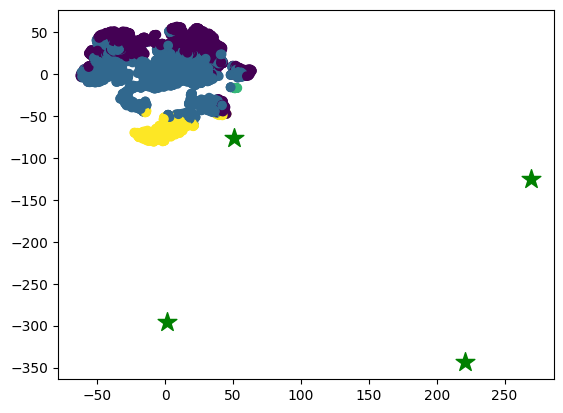

In [81]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, learning_rate=200, init='random')
X_tsne = tsne.fit_transform(X)
cluster_tsne = tsne.fit_transform(kmeans.cluster_centers_)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_)
plt.scatter(cluster_tsne[:, 0], cluster_tsne[:, 1], marker='*', s=200, c='green')
plt.show()
